In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/scene-classification/test_WyRytb0.csv
/kaggle/input/scene-classification/train-scene classification/train.csv
/kaggle/input/scene-classification/train-scene classification/train/19812.jpg
/kaggle/input/scene-classification/train-scene classification/train/22735.jpg
/kaggle/input/scene-classification/train-scene classification/train/16916.jpg
/kaggle/input/scene-classification/train-scene classification/train/7981.jpg
/kaggle/input/scene-classification/train-scene classification/train/22706.jpg
/kaggle/input/scene-classification/train-scene classification/train/20513.jpg
/kaggle/input/scene-classification/train-scene classification/train/12666.jpg
/kaggle/input/scene-classification/train-scene classification/train/13288.jpg
/kaggle/input/scene-classification/train-scene classification/train/20088.jpg
/kaggle/input/scene-classification/train-scene classification/train/6234.jpg
/kaggle/input/scene-classification/train-scene classification/train/1269.jpg
/kaggle/input/scene-c

In [3]:
# Import necessary packages
import numpy as np
import pandas as pd
import os
import keras
from keras import Model 
from keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten, GlobalAveragePooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Set a random seed for reproducibility
np.random.seed(42)


In [4]:
# Load the dataset
Dataset = pd.read_csv("/kaggle/input/scene-classification/train-scene classification/train.csv") 

# Convert class number to strings
Dataset["label"] = Dataset["label"].astype(str)

# Split the data into train and test subsets
Data_train, Data_test = train_test_split(Dataset, test_size=0.2)

# Define image data generator
datagen = ImageDataGenerator(rescale=1./255)

# Define training set directory
dir1='/kaggle/input/scene-classification/train-scene classification/train/'


In [5]:
# Generate training data
train_gen=datagen.flow_from_dataframe(
    dataframe = Data_train,          
    directory=dir1,                   
    batch_size=20,                    
    class_mode="categorical",         
    x_col="image_name",               
    color_mode="rgb",                 
    y_col="label",                    
    target_size=(224,224))

Found 13627 validated image filenames belonging to 6 classes.


In [6]:
# Generate validation data
valid_gen=datagen.flow_from_dataframe(
    dataframe = Data_test,           
    directory=dir1,                  
    batch_size=20,                   
    class_mode="categorical",        
    x_col="image_name",              
    color_mode="rgb",                
    y_col="label",                   
    target_size=(224,224))

Found 3407 validated image filenames belonging to 6 classes.


1st Model -  ResNet - Fine-Tuned CNN

In [8]:
import tensorflow as tf

# Load ResNet model for transfer learning
ResNet_model = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in ResNet model and add additional layers
for layer in ResNet_model.layers[:-15]:      
    layer.trainable = False

x = ResNet_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(units=512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(units=512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
output  = tf.keras.layers.Dense(units=6, activation='softmax')(x)

# Create the final model
model = tf.keras.Model(ResNet_model.input, output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=['accuracy'])

In [18]:
#Train the model
STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=valid_gen.n//valid_gen.batch_size

transfer_learning_history = model.fit(
    x=train_gen,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_gen,
    validation_steps=STEP_SIZE_VALID,
    epochs=3)

Epoch 1/3
681/681 [==============================] - 160s 235ms/step - loss: 0.0337 - accuracy: 0.9890 - val_loss: 0.5222 - val_accuracy: 0.9174
Epoch 2/3
681/681 [==============================] - 159s 233ms/step - loss: 0.0423 - accuracy: 0.9900 - val_loss: 0.4554 - val_accuracy: 0.9185
Epoch 3/3
681/681 [==============================] - 145s 213ms/step - loss: 0.0347 - accuracy: 0.9910 - val_loss: 0.4498 - val_accuracy: 0.9218


In [19]:
# Evaluate the model on the test set
test_gen = datagen.flow_from_dataframe(
    dataframe=Data_test,
    directory=dir1,
    batch_size=20,
    class_mode="categorical",
    x_col="image_name",
    color_mode="rgb",
    y_col="label",
    target_size=(224, 224),
    shuffle=False
)

# Reset the test generator
test_gen.reset()

# Predict classes
pred = model.predict(test_gen)

# Convert probabilities to class labels
pred_classes = np.argmax(pred, axis=1)

true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())   

# Print classification report
print(classification_report(true_classes, pred_classes, target_names=class_labels))

Found 3407 validated image filenames belonging to 6 classes.
171/171 [==============================] - 26s 153ms/step
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       548
           1       0.99      0.98      0.98       550
           2       0.88      0.86      0.87       599
           3       0.89      0.87      0.88       594
           4       0.95      0.97      0.96       554
           5       0.91      0.94      0.92       562

    accuracy                           0.92      3407
   macro avg       0.92      0.92      0.92      3407
weighted avg       0.92      0.92      0.92      3407



2. Custom DNN


In [22]:
import tensorflow as tf

In [32]:
# Load ResNet model for transfer learning
ResNet_model = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in ResNet model and add additional layers
for layer in ResNet_model.layers[:-15]:
    layer.trainable = False

In [34]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

In [35]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
# Train the model
STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size

transfer_learning_history = model.fit(
    x=train_gen,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_gen,
    validation_steps=STEP_SIZE_VALID,
    epochs=5
)


Epoch 1/5
681/681 [==============================] - 36s 53ms/step - loss: 0.4559 - accuracy: 0.8480 - val_loss: 0.5775 - val_accuracy: 0.8009
Epoch 2/5
681/681 [==============================] - 37s 54ms/step - loss: 0.3249 - accuracy: 0.8882 - val_loss: 0.6040 - val_accuracy: 0.8109
Epoch 3/5
681/681 [==============================] - 40s 58ms/step - loss: 0.2412 - accuracy: 0.9186 - val_loss: 0.7214 - val_accuracy: 0.8168
Epoch 4/5
681/681 [==============================] - 37s 54ms/step - loss: 0.1825 - accuracy: 0.9419 - val_loss: 0.7912 - val_accuracy: 0.8109
Epoch 5/5
681/681 [==============================] - 43s 63ms/step - loss: 0.1431 - accuracy: 0.9558 - val_loss: 0.8727 - val_accuracy: 0.8041


In [40]:
# Evaluate the model on the test set
test_gen = datagen.flow_from_dataframe(
    dataframe=Data_test,
    directory=dir1,
    batch_size=20,
    class_mode="categorical",
    x_col="image_name",
    color_mode="rgb",
    y_col="label",
    target_size=(224, 224),
    shuffle=False
)

Found 3407 validated image filenames belonging to 6 classes.


In [41]:
# Reset the test generator
test_gen.reset()

In [42]:
# Predict classes
pred = model.predict(test_gen)

171/171 [==============================] - 7s 38ms/step


In [44]:
# Convert probabilities to class labels
pred_classes = np.argmax(pred, axis=1)

In [47]:
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices)

In [1]:
# Generate the confusion matrix
confusion_mtx = confusion_matrix(true_classes, pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

NameError: name 'datagen' is not defined

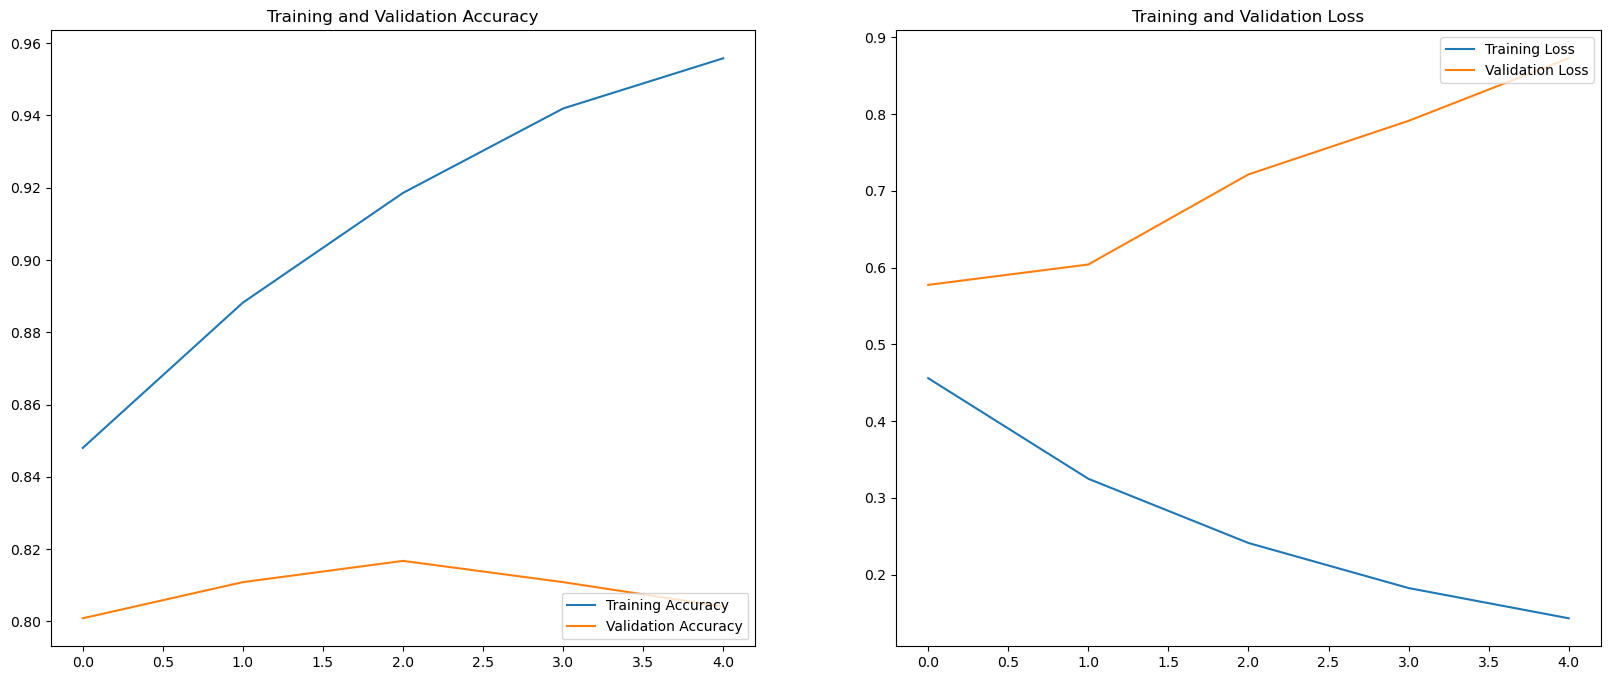

In [49]:
# Plot the training and validation accuracy and loss
acc = transfer_learning_history.history['accuracy']
val_acc = transfer_learning_history.history['val_accuracy']

loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
